In [11]:
import pandas as pd
import numpy as np

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_curve, auc

In [14]:
submission_data_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv')
submission_data_test

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370
...,...,...,...,...
42256,120745,1539247150,correct,448
42257,120745,1540380070,wrong,9418
42258,120745,1543165802,correct,8093
42259,120745,1544465625,wrong,25737


In [15]:
events_data_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv')
events_data_test

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417
...,...,...,...,...
274763,158433,1545846175,discovered,3649
274764,158433,1545846175,passed,3649
274765,158433,1545846283,viewed,20953
274766,158433,1545846283,discovered,20953


In [16]:
submission_example = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_example.csv')
submission_example

,user_id,is_gone
0,12,0.26
1,13,0.79
2,15,0.12
3,21,0.67
4,35,0.62
...,...,...
6179,7315,0.72
6180,24300,0.35
6181,820,0.88
6182,3649,0.38


# Предобработка и подготовка данных в обучению

In [18]:
events_data = pd.read_csv("https://stepik.org/media/attachments/course/4852/event_data_train.zip")
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [19]:
users_events_data = events_data.pivot_table(index='user_id', columns='action', 
                                            values='step_id', aggfunc='count', fill_value=0).reset_index()

In [20]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [21]:
submissions_data = pd.read_csv("https://stepik.org/media/attachments/course/4852/submissions_data_train.zip")
submissions_data

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [22]:
users_scores = submissions_data.pivot_table(index='user_id', columns='submission_status', 
                                            values='step_id', aggfunc='count', fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [23]:
users_data = users_events_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)

In [24]:
users_data

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
1,2,9,9,2,10,2.0,0.0
2,3,91,87,30,192,29.0,23.0
3,5,11,11,4,12,2.0,2.0
4,7,1,1,0,1,0.0,0.0
...,...,...,...,...,...,...,...
19229,26790,8,8,1,9,1.0,0.0
19230,26793,1,0,1,1,0.0,0.0
19231,26794,69,69,34,180,33.0,9.0
19232,26797,10,10,2,13,2.0,0.0


In [64]:
users_data['passed_course'] = users_data.passed >= 40

In [26]:
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,passed_course
0,1,1,0,0,1,0.0,0.0,False
1,2,9,9,2,10,2.0,0.0,False
2,3,91,87,30,192,29.0,23.0,True
3,5,11,11,4,12,2.0,2.0,False
4,7,1,1,0,1,0.0,0.0,False


In [27]:
user_min_time = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'min'}) \
                .rename({'timestamp': 'min_timestamp'}, axis=1)

In [28]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [29]:
users_data = users_data.merge(user_min_time, how='outer')

In [30]:
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,passed_course,min_timestamp
0,1,1,0,0,1,0.0,0.0,False,1472827464
1,2,9,9,2,10,2.0,0.0,False,1514383364
2,3,91,87,30,192,29.0,23.0,True,1434358476
3,5,11,11,4,12,2.0,2.0,False,1466156809
4,7,1,1,0,1,0.0,0.0,False,1521634660


In [31]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [32]:
events_data.head()

,step_id,timestamp,action,user_id,user_time
0,32815,1434340848,viewed,17632,17632_1434340848
1,32815,1434340848,passed,17632,17632_1434340848
2,32815,1434340848,discovered,17632,17632_1434340848
3,32811,1434340895,discovered,17632,17632_1434340895
4,32811,1434340895,viewed,17632,17632_1434340895


In [33]:
learning_time_threshold = 2 * 24 * 60 * 60
learning_time_threshold

172800

In [34]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [35]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold
user_min_time.head()

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473000264
1,2,1514383364,2_1514556164
2,3,1434358476,3_1434531276
3,5,1466156809,5_1466329609
4,7,1521634660,7_1521807460


In [36]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [37]:
events_data.head()

,step_id,timestamp,action,user_id,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,17632_1434340848,17632_1434513648
1,32815,1434340848,passed,17632,17632_1434340848,17632_1434513648
2,32815,1434340848,discovered,17632,17632_1434340848,17632_1434513648
3,32811,1434340895,discovered,17632,17632_1434340895,17632_1434513648
4,32811,1434340895,viewed,17632,17632_1434340895,17632_1434513648


In [40]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [38]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [39]:
events_data['day'] = events_data.date.dt.date

In [41]:
events_data_train.groupby('user_id').day.nunique().max()

3

In [42]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [43]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [44]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [45]:
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

3

In [46]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_learning_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434518777
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434518777
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434518777
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,15853_1434348188,15853_1434518777
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,15853_1434347371,15853_1434518777


# Собираем конечные датасеты для обучения

In [74]:
X_train = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename({'day': 'days'})

steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'})

X_train = X_train.merge(steps_tried, on='user_id', how='outer')

X_train = X_train.merge(submissions_data_train.pivot_table(index='user_id',
                                  columns='submission_status', 
                                  values='step_id',
                                  aggfunc='count', 
                                  fill_value=0).reset_index())

X_train['correct_ratio'] = X_train.correct / (X_train.correct + X_train.wrong)

X_train = X_train.merge(events_data_train.pivot_table(index='user_id', 
                                         columns='action', 
                                         values='step_id',
                                         aggfunc='count', 
                                         fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

X_train = X_train.fillna(0)

X_train = X_train.merge(users_data[['user_id', 'passed_course']], how='outer')

y_train = X_train.passed_course.map(int)

X_train = X_train.drop(['passed_course'], axis=1)
X_train = X_train.set_index(X_train.user_id)
X_train = X_train.drop('user_id', axis=1)

In [75]:
X_train.head()

,day,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.000000,9
3,1.0,4.0,4.0,4.0,0.500000,20
8,1.0,11.0,9.0,21.0,0.300000,154
14,1.0,1.0,0.0,1.0,0.000000,9
16,2.0,18.0,18.0,23.0,0.439024,117


In [77]:
y_train.head()

0    0
1    1
2    1
3    0
4    1
Name: passed_course, dtype: int64

# Подготавливаем тестовые данные

In [60]:
submission_data_test['date'] = pd.to_datetime(submission_data_test.timestamp, unit='s')
submission_data_test['day'] = submission_data_test.date.dt.date
submission_data_test.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20
3,31971,1526801054,correct,24370,2018-05-20 07:24:14,2018-05-20
4,31972,1526800664,wrong,24370,2018-05-20 07:17:44,2018-05-20


In [63]:
submission_data_test.user_id.nunique()

2803

In [69]:
events_data_test.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [88]:
users_events_data_test = events_data_test.pivot_table(index='user_id', columns='action', 
                                            values='step_id', aggfunc='count', fill_value=0).reset_index()

users_events_data_test['passed_course'] = users_events_data_test.passed >= 40

users_scores_test = submission_data_test.pivot_table(index='user_id', columns='submission_status', 
                                            values='step_id', aggfunc='count', fill_value=0).reset_index()

users_data_test = users_events_data_test.merge(users_scores_test, on='user_id', how='outer')
users_data_test = users_data_test.fillna(0)

users_data_test.head()

,user_id,discovered,passed,started_attempt,viewed,passed_course,correct,wrong
0,4,1,1,0,1,False,0.0,0.0
1,6,1,1,0,1,False,0.0,0.0
2,10,2,2,0,6,False,0.0,0.0
3,12,11,9,4,14,False,1.0,0.0
4,13,70,70,35,105,True,29.0,36.0


In [89]:
users_data_test.passed_course.nunique()

2

In [122]:
X_test = submission_data_test.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename({'day': 'days'})

steps_tried = submission_data_test.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'})

X_test = X_test.merge(steps_tried, on='user_id', how='outer')

X_test = X_test.merge(submission_data_test.pivot_table(index='user_id',
                                  columns='submission_status', 
                                  values='step_id',
                                  aggfunc='count', 
                                  fill_value=0).reset_index())

X_test['correct_ratio'] = X_test.correct / (X_test.correct + X_test.wrong)

X_test = X_test.merge(events_data_test.pivot_table(index='user_id', 
                                         columns='action', 
                                         values='step_id',
                                         aggfunc='count', 
                                         fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

X_test = X_test.fillna(0)

X_test = X_test.merge(users_data_test[['user_id', 'passed_course']], how='outer')

y_test = X_test.passed_course.map(int)

X_test = X_test.drop(['passed_course'], axis=1)

users = X_test.user_id

X_test = X_test.set_index(X_test.user_id)
X_test = X_test.drop('user_id', axis=1)

In [95]:
X_test

,day,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
12,1.0,1.0,1.0,0.0,1.000000,14
13,2.0,29.0,29.0,36.0,0.446154,105
15,3.0,11.0,10.0,30.0,0.250000,1
21,1.0,30.0,24.0,103.0,0.188976,98
35,3.0,9.0,7.0,35.0,0.166667,70
...,...,...,...,...,...,...
26745,0.0,0.0,0.0,0.0,0.000000,1
26768,0.0,0.0,0.0,0.0,0.000000,1
26791,0.0,0.0,0.0,0.0,0.000000,1


In [96]:
y_test

0       0
1       1
2       0
3       1
4       0
       ..
6179    0
6180    0
6181    0
6182    0
6183    0
Name: passed_course, Length: 6184, dtype: int64

# Обучаем модель

In [98]:
clf = tree.DecisionTreeClassifier()

In [99]:
parameters = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 15), 
              'min_samples_split': range(2, 10), 'min_samples_leaf': range(1, 10)}

In [100]:
grid_search_cv_clf = GridSearchCV(clf, parameters, cv=5)

In [101]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 15),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10)})

In [102]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(max_depth=2)

In [103]:
best_clf.score(X_test, y_test)

0.8547865459249676

In [104]:
y_pred = best_clf.predict(X_test)

In [105]:
precision_score(y_test, y_pred)

0.3033884948778566

In [106]:
recall_score(y_test, y_pred)

0.9649122807017544

In [118]:
y_predicted_prob = best_clf.predict_proba(X_test)
probability = pd.Series(y_predicted_prob[:, 1])
probability

0       0.261698
1       0.947784
2       0.562386
3       0.947784
4       0.562386
          ...   
6179    0.058541
6180    0.058541
6181    0.058541
6182    0.058541
6183    0.058541
Length: 6184, dtype: float64

In [126]:
Predict = pd.DataFrame({'user_id': users, 'is_gone': probability})

In [127]:
Predict.to_csv('predict.csv')

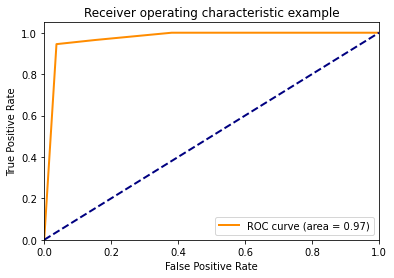

In [108]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()